In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [24]:
import time
import csv

import cv2
import numpy as np

from lib.tsdf_fusion import fusion

from tqdm import tqdm

import os, os.path as osp
from pathlib import Path

import matplotlib.pyplot as plt

In [91]:
DATA_DIR = Path('/mnt/data/scannet/scans/')
IMG_SIZE = (640, 480)

In [92]:
scan_id = 'scene0000_00'
scan_dir = DATA_DIR / scan_id
pose_dir = scan_dir / 'pose'
depth_dir = scan_dir / 'depth'
color_dir = scan_dir / 'color'
label_dir = scan_dir / 'label-filt'
label_file = DATA_DIR.parent / 'scannetv2-labels.combined.tsv'

intrinsic_dir = scan_dir / 'intrinsic'
intrinsic_path = intrinsic_dir / 'intrinsic_color.txt'
intrinsic_mat = np.genfromtxt(intrinsic_path, delimiter=' ')[:3, :3]

## map ScanNet labels to NYU40 labels

In [93]:
# map scannet -> nyu40
def map_label_image(image, label_mapping):
    mapped = np.copy(image)
    for k,v in label_mapping.items():
        mapped[image==k] = v
    return mapped.astype(np.uint8)

# if string s represents an int
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

# read the TSV file
def read_label_mapping(filename, label_from='id', label_to='nyu40id'):
    assert os.path.isfile(filename)
    mapping = dict()
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t')
        for row in reader:
            mapping[row[label_from]] = int(row[label_to])
    # if ints convert 
    if represents_int(list(mapping.keys())[0]):
        mapping = {int(k):v for k,v in mapping.items()}
    return mapping

def create_color_palette():
    return [
       (0, 0, 0),
       (174, 199, 232),  # wall
       (152, 223, 138),  # floor
       (31, 119, 180),   # cabinet
       (255, 187, 120),  # bed
       (188, 189, 34),   # chair
       (140, 86, 75),    # sofa
       (255, 152, 150),  # table
       (214, 39, 40),    # door
       (197, 176, 213),  # window
       (148, 103, 189),  # bookshelf
       (196, 156, 148),  # picture
       (23, 190, 207),   # counter
       (178, 76, 76),  
       (247, 182, 210),  # desk
       (66, 188, 102), 
       (219, 219, 141),  # curtain
       (140, 57, 197), 
       (202, 185, 52), 
       (51, 176, 203), 
       (200, 54, 131), 
       (92, 193, 61),  
       (78, 71, 183),  
       (172, 114, 82), 
       (255, 127, 14),   # refrigerator
       (91, 163, 138), 
       (153, 98, 156), 
       (140, 153, 101),
       (158, 218, 229),  # shower curtain
       (100, 125, 154),
       (178, 127, 135),
       (120, 185, 128),
       (146, 111, 194),
       (44, 160, 44),    # toilet
       (112, 128, 144),  # sink
       (96, 207, 209), 
       (227, 119, 194),  # bathtub
       (213, 92, 176), 
       (94, 106, 211), 
       (82, 84, 163),    # otherfurn
       (100, 85, 144)
    ]

# color by label
def visualize_label_image(image):
    height = image.shape[0]
    width = image.shape[1]
    vis_image = np.zeros([height, width, 3], dtype=np.uint8)
    color_palette = create_color_palette()
    for idx, color in enumerate(color_palette):
        vis_image[image==idx] = color
        
    return vis_image

## read images

In [96]:
ndx = 10

# read a depth image 
fpath = depth_dir / f'{ndx}.png'
print(fpath)
depth = cv2.imread(str(fpath), -1)
print(depth.min(), depth.max(), depth.shape)

# color image
fpath = color_dir / f'{ndx}.jpg'
print(fpath)
color = cv2.imread(str(fpath), cv2.IMREAD_COLOR)
print(color.min(), color.max(), color.shape)

# raw label image - scannet labels
fpath = label_dir / f'{ndx}.png'
print(fpath)
label = cv2.imread(str(fpath), -1).astype(np.uint16)
label = cv2.resize(label, IMG_SIZE)
print(label.min(), label.max(), label.shape)

# map labels
mapping = read_label_mapping(label_file, label_from='id', label_to='nyu40id')
mapped_img = map_label_image(label, mapping)
viz_img = visualize_label_image(mapped_img)
print(viz_img.min(), viz_img.max(), viz_img.shape)

/mnt/data/scannet/scans/scene0000_00/depth/10.png
0 3036 (480, 640)
/mnt/data/scannet/scans/scene0000_00/color/10.jpg
0 255 (480, 640, 3)
/mnt/data/scannet/scans/scene0000_00/label-filt/10.png
0 63 (480, 640)
0 255 (480, 640, 3)


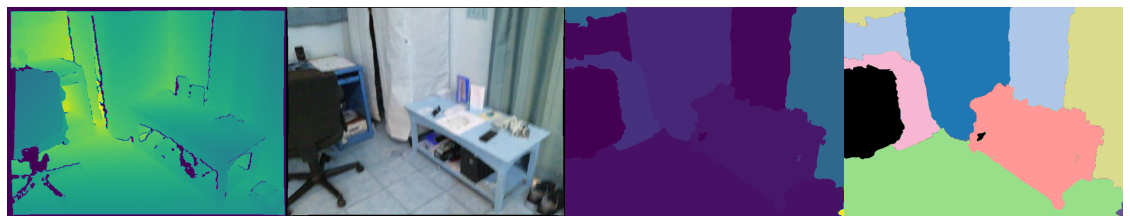

In [97]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(wspace=0, hspace=0)

ax = fig.subplots(1,4) 

for i, img in enumerate((depth, color, label, viz_img)):
    ax[i].imshow(img)
    ax[i].axis('off')

## Get volume vounds

In [7]:
vol_bnds = np.zeros((3,2))

for depth_name in tqdm(os.listdir(depth_dir)):
    # index of the file - needed when frames are skipped
    ndx = Path(depth_name).stem
    pose = np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' ')
#     pose = np.linalg.inv(np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' '))
    
    depth = cv2.imread(str(depth_dir / depth_name), -1).astype(float)
    # convert mm to m
    depth /= 1000.0
    
    view_frust_pts = fusion.get_view_frustum(depth, intrinsic_mat, pose)
    # todo: why does this return nan values?
    if not np.isnan(view_frust_pts).any():
        vol_bnds[:,0] = np.minimum(vol_bnds[:,0], np.amin(view_frust_pts, axis=1))
        vol_bnds[:,1] = np.maximum(vol_bnds[:,1], np.amax(view_frust_pts, axis=1))

100%|██████████| 1288/1288 [00:03<00:00, 367.47it/s]


In [8]:
vol_bnds

array([[-3.01274317, 13.90645685],
       [-1.10563202, 12.43302728],
       [-1.21150758,  3.63453529]])

## Create voxel grid

In [199]:
tsdf_vol = fusion.TSDFVolume(vol_bnds, voxel_size=0.04)

t0_elapse = time.time()

for depth_name in tqdm(os.listdir(depth_dir)):
    ndx = Path(depth_name).stem
    pose = np.genfromtxt(pose_dir / f'{ndx}.txt', delimiter=' ')
    
    color = cv2.imread(str(color_dir / f'{ndx}.jpg'), cv2.IMREAD_COLOR)
    depth = cv2.imread(str(depth_dir / depth_name), -1).astype(float)
                       
    # convert mm to m
    depth /= 1000.0
    
    tsdf_vol.integrate(color, depth, intrinsic_mat, pose, obs_weight=1.)
    
fps = len(os.listdir(depth_dir)) / (time.time() - t0_elapse)
print("Average FPS: {:.2f}".format(fps))

Voxel volume size: 314 x 344 x 142 - # points: 15,338,272


100%|██████████| 1544/1544 [16:47<00:00,  1.53it/s]

Average FPS: 1.53


In [200]:
tsdf, color_float = tsdf_vol.get_volume()
print('tsdf', tsdf.min(), tsdf.max(), tsdf.shape)
print('color_float', color_float.min(), color_float.max(), color_float.shape)

rgb = float_color_to_int(color_float)
print(rgb.min(), rgb.max(), rgb.shape)

tsdf -0.99999845 1.0 (314, 344, 142)
color_float 0.0 16777215.0 (314, 344, 142)
0 255 (314, 344, 142, 3)


In [128]:
def float_color_to_int(arr):
    '''
    arr: float32 containing color
        = R, G, B 8 bits each
    '''
    const = 256 * 256
    # rightmost value
    b = np.floor(arr / const)
    # middle value
    g = np.floor((arr - b * const)/256)
    # leftmost value
    r = arr - (b * const) - (g * 256)
    
    rgb = np.floor(np.stack((r, g, b), axis=-1)).astype(np.uint8)
    
    return rgb 


## save mesh

In [201]:
verts, faces, norms, colors = tsdf_vol.get_mesh()
fusion.meshwrite(scan_dir / f'{scan_id}_voxelized.ply', verts, faces, norms, colors)

In [202]:
point_cloud = tsdf_vol.get_point_cloud()
fusion.pcwrite(scan_dir / f'{scan_id}_pc.ply', point_cloud)